---
author: Mojo Dojo
author_site: https://mojodojo.dev
author_image: https://mojodojo.dev/hero.png
excerpt: Comparing the experience of rewriting C/C++/Python with Rust and Mojo
date: 2023-07-17
feed: true
head:
  - [meta, { name: twitter:card , content: summary }]
  - [meta, { name: twitter:site , content: "@mojodojodev" }]
  - [meta, { name: twitter:title , content: "Rust or Mojo for the future of AI?" }]
  - [meta, { name: twitter:description , content: "Comparing the experience of rewriting C++ and Python with Rust and Mojo" }]
  - [meta, { name: twitter:image , content: "https://mojodojo.dev/hero.png" }]
---

# Rust or Mojo for the future of AI?
## Intro
There has been dissatisfaction with the combination of C/C++ and Python for putting ML models into production, debugging problems when something goes wrong can be a nightmarish task, ideally we could have one language that allows systems programmers to squeeze our hardware to the limits of physics, while also being suitable as a safe high level language to make putting code into production easy, reliable and performant. Rust fits that space well despite having a steep learning curve, and it's starting to be noticed in the industry as a potential solution.

Converting production code that uses computer vision ML models from C/C++/Python to Rust is a nice experience on the surface, Rust works well as a high level safe and expressive language with very low performance overhead. But the ecosystem is still young, and so we still rely on huge C++ projects like opencv, which itself relies on huge C++ projects like ffmpeg for image and video encoding and decoding. The experience of linking to these libraries can be quite painful, especially statically, and squeezing performance out of SIMD registers or other specialized hardware requires even more complexity. It begins to feel redundant when you end up with hundreds of megabytes of `.so` dependencies while wrapping C/C++ in unsafe Rust.

## C++ Dependencies
There is an ongoing attempt to [rewrite opencv functionality](https://github.com/rust-cv/cv/graphs/contributors?from=2019-05-05&to=2019-05-17&type=c) in Rust but it hasn't picked up much steam since it was introduced in 2019 with very little activity now, and it only really scratches the surface. Many are using [opencv-rust C++ bindings](https://github.com/twistedfall/opencv-rust) which are maintained by a dedicated, but mostly solo contributor. It gives you everything needed for computer vision, including the aforementioned ffmpeg to decode video and get frames into a tensor. Then to boost performance on ML models the fastest solution in my benchmarks was to convert TensorFlow and PyTorch models to ONNX and use libonnxruntime bindings from a crate named [ort](https://github.com/pykeio/ort). There is a good Rust native implementation named [tract-onnx](https://github.com/sonos/tract) but it doesn't have many contributors so is missing operators, is slow with other operators, and only runs on CPU. The [ort](https://github.com/pykeio/ort) fork of the original outdated libonnxruntime bindings is faster for all the models I've benchmarked, plus the `libonnxruntime.so` dependency is very small and easy to statically link, and some larger companies like Twitter have started using it.

## C++ from Rust
The tensor representation in opencv is a `Matrix`, a bit of a misnomer as it can contain more than 2 dimensions, `ort` uses a Rust native crate named `ndarray` for it's tensor type, they both have the same C row-major representation in memory, so we can get performance improvements by dipping into unsafe Rust and bitcasting the Rust native `ndarray::Array` as the C++ native `opencv::Matrix` without copying any data. However writing `unsafe` Rust around C++ libraries is [not always the most pleasant experience](https://zackoverflow.dev/writing/unsafe-rust-vs-zig/), and with the vast majority of AI researchers being Python users who aren't interested in learning Rust, it's unlikely that it will ever get significant adoption in ML. It'll never be as ergonomic for researchers as the combination of `opencv-python`, `numpy`, `pytorch` etc.

What if we could keep the beauty and simplicity of Python as a high level language, and rewrite one function at a time in Mojo to get better performance, removing the complexity and indirections of all the C/C++/Fortran dependencies?

## Rewriting C/C++/Python with Mojo
Instead of adding more complexity on top of C++, let's see how we can use Mojo to simplify things and get even faster performance.

Currently Mojo is only available from an online Jupyter notebook (local release should be in the next few months), so to benchmark we're going to need to need to run Python from the same notebook environment.

We'll be taking a png of a fire emoji, manually implementing a box blur in python, then using an optimized opencv function, and rewriting it in Mojo to remove all the underlying C/C++/OpenCL complexity.

First we need a way to open and render the images, because we can use the entire Python ecosystem from Mojo, we'll use opencv to get our images into a numpy array, and matplotlib to render them:

In [1]:
%%python
import cv2
import numpy as np
from matplotlib import colors, pyplot as plt
from timeit import timeit

def render(img):
    plt.figure(figsize=(2, 2))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

def open(img):
    img = cv2.imread(img).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    return img

In the Mojo playground `%%python` represents a cell that runs through the Python interpreter, but we can still access that code from inside Mojo cells, for example:

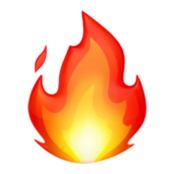

In [2]:
img = open("fire.png")
render(img)

When using opencv from python, instead of a `Mat` like in C++ we get back the ultra ergonomic numpy array, for example printing out the RGBA of the first pixel (all white):

In [5]:
%%python
print(img[0, 0, 0:4])

[255 255 255 255]


The format is: [Red, Green, Blue, Alpha] represented by 8bit unsigned integers.

Or a middle pixel with some color:

In [6]:
%%python
print(img[120, 120, 0:4])

[253 162  54 255]


Let's try applying a blur using python first:

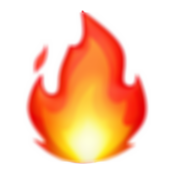

In [7]:
%%python
def box_blur(image, diameter):
    blurred_image = np.copy(image)
    height, width, _ = image.shape
    radius = diameter // 2

    for x in range(radius, height - radius):
        for y in range(radius, width - radius):
            avg = np.mean(image[x-radius:x+radius+1, y-radius:y+radius+1], axis=(0, 1))
            blurred_image[x, y] = avg

    return blurred_image

blurred = box_blur(img, 8)
render(blurred)

This is obviously going to be a very slow operation in Python compared to what you can do in a language like C, let's time how long it takes in the Mojo Playground:

In [18]:
%%python
img = open("fire.png")
python_secs = timeit(lambda: box_blur(img, 8), number = 5) / 5
print(python_secs)

0.5885662619955838


The opencv version of the operation uses C++ and one of a few hardware APIs depending on how it was compiled, which takes advantage of vectorization, first lets take a look at the result to make sure it's doing the same thing:

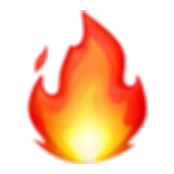

In [19]:
%%python
img = open("fire.png")
img = cv2.filter2D(img, -1, np.ones((8, 8))/64)
render(img)

And now we can time it:

In [22]:
%%python
img = open("fire.png")
opencv_secs = timeit(lambda: cv2.filter2D(img, -1, np.ones((8, 8), np.uint8)/64), number=5) / 5
print("Seconds:", opencv_secs)

Seconds: 0.001513117179274559


That's giving us a nice speedup of around 400x over the Python version:

In [23]:
print("Speedup:", python_secs / opencv_secs)

Speedup: 388.97599608099284


Going to the definition of `filter2D` we find the below code, the `...` means the C++ functions have default values, these are just for type hints in Python, the overload with `UMat` is for when you're using the GPU version of opencv:

```mojo
@typing.overload
def filter2D(src: cv2.typing.MatLike, ddepth: int, kernel: cv2.typing.MatLike, dst: cv2.typing.MatLike | None = ..., anchor: cv2.typing.Point = ..., delta: float = ..., borderType: int = ...) -> cv2.typing.MatLike: ...
@typing.overload
def filter2D(src: UMat, ddepth: int, kernel: UMat, dst: UMat | None = ..., anchor: cv2.typing.Point = ..., delta: float = ..., borderType: int = ...) -> UMat: ...
```

Then if you do a search for filter2D in [the opencv C++ source code](https://github.com/search?q=repo%3Aopencv%2Fopencv+filter2D&type=code) you'll find 5 pages of results where `filter2D` is defined, likely your version of opencv will be running through OpenCL to take advantage of your CPU SIMD registers, so if you want to contribute a faster version not only will you need to [figure out how OpenCL works](https://www.nersc.gov/assets/pubs_presos/MattsonTutorialSC14.pdf), you'll also need to learn know how to use SIMD intrinsics from C++ as a fallback.

There is a lot more going on underneath the hood, for example `ffmpeg` decoding the image and putting it into a `numpy` array for us. A lot of engineering hours and complexity went into making the API's so simple and easy to use while remaining fast. It's great for the Python user with an interface that is as close to English pseudo code as possible, but what if you wanted to build your own library to operate efficiently on numpy arrays?

You're going to have to know about:
- The C/C++ programming languages
- The Python [C API](https://docs.python.org/3/c-api/index.html)
- The [NumPy C API](https://numpy.org/doc/stable/reference/c-api/index.html), 
- How NumPy does [CPU/SIMD optimizations](https://numpy.org/doc/stable/reference/simd/index.html)
- How to [Interop with NumPy](https://numpy.org/doc/stable/user/basics.interoperability.html)

And if you're doing anything with linear algebra:
- The Fortran programming language
- [BLAS](https://www.netlib.org/blas/) 
- [LAPACK](https://www.netlib.org/lapack/)

Making your way down the stack to the actual Fortran routines requires many layers of indirection and is a daunting task, with Mojo we can learn one simple programming model that applies to CPU's, GPU's and even TPU's to replace all that complexity.

## Pointing to a CPython object from Mojo
The standard library is still being built up for Mojo, so sometimes we need to use foreign looking syntax to interact with [MLIR](https://mlir.llvm.org/) for things that haven't been added yet. Everything in Mojo lowers to MLIR, which is used to generate code for hardware-specific optimizations. It was built by Chris Lattner and his team at Google as a successor to LLVM because it allows the modularity required for ML and exotic hardware types. Since then it was open sourced with wide adoption and absorbed into the LLVM project, it still uses the legacy LLVM infrastructure for CPU codegen and optimization.

There is nothing in the standard library yet for converting a Python integer representing an address to a Mojo pointer with a given data type, so for now we need to write our own function:

In [14]:
from DType import DType
from Pointer import DTypePointer

fn numpy_data_pointer(numpy_array: PythonObject) raises -> DTypePointer[DType.uint32]:
    return DTypePointer[DType.uint32](
                __mlir_op.`pop.index_to_pointer`[
                    _type:__mlir_type.`!pop.pointer<scalar<ui32>>>`
                ](
                    SIMD[DType.index,1](numpy_array.__array_interface__['data'][0].__index__()).value
                )
            )

You can see `pop` is an MLIR dialect the Modular team have developed, it's not intended for normal programmers to need to understand this syntax, over time useful things will be wrapped in a nice API by compiler engineers for systems engineers and Python programmers to use at a higher level. But you still have the power to define your own dialects or use one of the many already defined in the MLIR ecosystem, which makes it easy for vendors to accelerate their hardware, for example you can take a look at the [gpu dialect](https://mlir.llvm.org/docs/Dialects/GPU/) here. This enables compiler engineers to write optimizations for different hardware as it becomes more exotic for AI acceleration, and Mojo developers will be able to take full advantage.

Lets go line by line to explain what's happening:

```mojo
fn numpy_array_pointer(numpy_array: PythonObject) raises -> DTypePointer[DType.uint32]:
```

`PythonObject` has the same representation in Mojo as it does in Python see [Intro to Mojo: Basic Types](/guides/intro-to-mojo/basic-types.html) for more details, `raises` means that an error could occur which is always the case when interacting with Python, here I'm returning a Pointer to a DType of `uint32` so each element represents the RGBA of a single pixel.

```mojo
__mlir_op.`pop.index_to_pointer`[
```

This is the operation to convert from an index which is an integer of size that matches your architecture e.g. 64bit on x86-64 machine, to an address that can be used as a pointer.

```mojo
_type:__mlir_type.`!pop.pointer<scalar<ui32>>>`
```

This is the type as represented in MLIR, it's 32bits so each element encompasses 4*8bit color channels representing RGBA.

```mojo
SIMD[DType.index,1](numpy_array.__array_interface__['data'][0].__index__()).value
```
Let's split the above into three separate parts:

```mojo
numpy_array.__array_interface__['data'][0]
```
This is using the Python interpreter to get back the address of where the raw data of the numpy array starts in memory.

```
.__index__()
```
This converts it from a PythonObject to a Mojo `Int`
```
SIMD[DType.index,1](...).value
```
This gets us back a raw MLIR `scalar<index>` type which can then be converted to a `pointer<scalar<ui32>>>` type via the MLIR operation.

```
return DTypePointer[DType.uint32](...)
```
Finally it's returned as the desired type, which is a Mojo pointer starting at the address in memory where the raw data of the numpy array starts.

## Writing the Box Blur in Mojo

Below we're taking advantage of Mojo's builtin SIMD type, we figure out how many 32bit pixels we can operate on at once in the hardwares SIMD register, then for each pixel we accumulate the RGB values in a box around it and apply the average to give the blur effect. For example if our SIMD register is 512bits we can operate on 16 32bit pixels at once:

In [16]:
from TargetInfo import simdwidthof
from Memory import memcpy
from Time import now

fn box_blur_mojo[diameter: Int](image: PythonObject) raises:
    # Get number of elements that fit into your hardwares SIMD register
    alias simd_width = simdwidthof[DType.uint32]()
    # The amount of pixels that will be averaged in box around the target pixel
    alias pixels = diameter ** 2
    alias radius = diameter // 2
    # Use the function we defined earlier to point to the numpy arrays raw data
    let p = numpy_data_pointer(image)
    # Get the numpy dimensions from the Python iterpreter and convert them to Mojo ints
    let height = image.shape[0].__index__()
    let width = image.shape[1].__index__()
    let el = width * height
    # Because we don't want blurred pixels influencing the outcome of the next pixel, we allocate a new array
    let tmp = DTypePointer[DType.uint32].alloc(el)

    for y in range(0, height):
        # Step over the amount of elements we'll operate on at the same time with SIMD
        for x in range(0, width, simd_width):
            var sum_r = SIMD[DType.uint32, simd_width]()
            var sum_g = SIMD[DType.uint32, simd_width]()
            var sum_b = SIMD[DType.uint32, simd_width]()
            ## Loop through a box around the pixel
            for ky in range(-radius, radius):
                for kx in range(-radius, radius):
                    # Make sure not to go out of bounds
                    var ix = x + kx
                    var iy = y + ky
                    if ix < 0: ix = 0
                    if iy < 0: iy = 0
                    if ix >= width: ix = width -1
                    if iy >= height: iy = height - 1
                    # Grab the amount of 32bit RGBA pixels that can fit into your hardwares SIMD register
                    let rgb = p.simd_load[simd_width](iy * width + ix)
                    # and seperate out the RGB components using bit shifts and masking, adding the values to the sums
                    sum_r += rgb & SIMD[DType.uint32, simd_width](255)
                    sum_g += rgb >> 8 & SIMD[DType.uint32, simd_width](255)
                    sum_b += rgb >> 16 & SIMD[DType.uint32, simd_width](255)

            # Combine 8bit color channels back into 32bit pixel (last channel is alpha 255 for no transparency)
            # And divide by total pixels in the box to get the average colors
            let combined = (sum_r / pixels) | (sum_g / pixels << 8) | (sum_b / pixels << 16) |  (255 << 24)
            # Store all the pixels at once (16 on a 512bit SIMD register)
            tmp.simd_store(y * width + x, combined)
    # Copy the data from the temporay image to the original numpy array
    memcpy(p, tmp, el)

Now we can use a similar benchmark function as Python to take the average of 5 iterations:

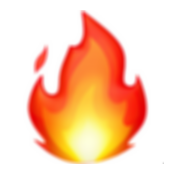


python speedup: 1310.019894025165
opencv speedup: 3.3678682160952467


In [24]:
var image = open("fire.png")
box_blur_mojo[8](image)
render(image)

var total = 0.0
let its = 5
for _ in range(its):
    let tick = now()
    box_blur_mojo[8](image)
    total += (now() - tick)
total = total / its / 1e9

print("python speedup:", python_secs / total)
print("opencv speedup:", opencv_secs / total)

We just replaced tens of thousands of lines of incredibly hard to understand C++ code accounting for all the different hardware API's that opencv supports, and still managed to get a 3x performance improvement. This can be further improved by splitting rows and running on separate cores, but didn't result in faster performance on my playground instance as the CPU is shared with other users, stay tuned for updates once the local compiler is released.

This isn't the fastest way to do a box blur, I chose this method because it's the fewest lines of code and easiest to explain.

## Conclusion
Overall I really enjoy working with computer vision and Rust as it's a fun language, but adding complexity is not going to help the ecosystem, it desperately needs simplification instead. As [Andrej Karpathy shows](https://www.youtube.com/watch?v=VMj-3S1tku0) neural networks are not complicated to implement, it's making them go fast on different hardware where all the complexity comes from, and because Mojo is focused on simplifying that process while allowing AI researchers to interact with their code from Python, I'm confident that it's going to be the path forward for the industry.



If you found any mistakes, incorrect information, or have faster benchmarks, please let me know in the comments below or [Edit this page on GitHub](https://github.com/mojodojodev/mojodojo.dev/edit/main/blog/2023-07-17-rust-or-mojo-ai.md) to raise a pull request!

<CommentService />